In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from sklearn.svm import SVC

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Generate dataset

In [2]:
y = np.random.randint(0,3,150)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 53
1 56
2 41


In [3]:
x = np.zeros((150,))
# x1 = np.zeros((500,2))

In [4]:
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =2,high =3,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =0,high =1,size= sum(idx[2]))



In [5]:
print(x.shape,y.shape)

(150,) (150,)


In [6]:
idx= []
for i in range(3):
    idx.append(y==i)

# visualise data distribution

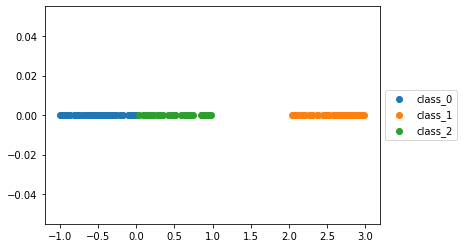

In [7]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
foreground_classes = {'class_0','class_1'}

background_classes = {'class_2'}

In [9]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,2)

a = []
for i in range(2):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,3)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
#print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
foreground 0 present at 1
0 1


In [10]:
a

array([ 0.66471976, -0.35077419])

In [11]:
desired_num = 1000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,2)
    fg_idx = np.random.randint(0,2)
    a = []
    for i in range(2):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(2,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [12]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
print(mosaic_list)

[[-0.35623866  0.21297637]
 [ 2.4912696   0.4663985 ]
 [ 2.37016755  0.03289332]
 ...
 [ 0.15036806  2.71776593]
 [ 0.96223938 -0.30946238]
 [ 0.5112176   2.92621607]]


In [13]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(1000,)
(1000,)


In [14]:
class MosaicDataset(Dataset):
    """MosaicDataset dataset."""
    
    
    def __init__(self, mosaic_list, mosaic_label, fore_idx):
        """
          Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mosaic = mosaic_list
        self.label = mosaic_label
        self.fore_idx = fore_idx

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=False)

In [15]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(1,1)

    def forward(self,z):
        x = torch.zeros([batch,2],dtype=torch.float64)
        y = torch.zeros([batch], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(2):
            x[:,i] = self.helper(z[:,i])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        
        #print("after network",x.shape)
        x1 = x[:,0]
        #print("alphas before",y.shape)
        for i in range(2):
            x1 = x[:,i]          
            #print(torch.mul(x1,z[:,i]).shape)
            y = y+torch.mul(x1,z[:,i])
            #print("alphas",y.shape)
        #print(y[0])
        return y[:,None] , x 

    
    def helper(self,x):
        #print(x.shape)
        x = self.linear1(x[:,None])
#         x = F.relu(self.linear2(x))
#         x = self.linear3(x)
        return x

    

In [16]:
trainiter = iter(train_loader)
input1,labels1,index1 = trainiter.next()



In [47]:
where = Wherenet().double()
where = where
out_avg,alphas = where(input1)
#out_where.shape,alphas.shape

In [48]:
out_avg.shape,alphas.shape

(torch.Size([250, 1]), torch.Size([250, 2]))

In [49]:
X = []
Y = []
for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
        
    X.append(inputs.numpy())
    Y.append(labels.numpy())
X = np.concatenate(X,axis=0)
Y  = np.concatenate(Y,axis=0)

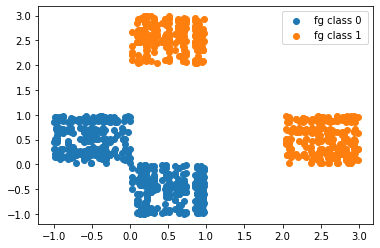

In [50]:
plt.scatter(X[Y==0,0],X[Y==0,1],label = "fg class 0 ")
plt.scatter(X[Y==1,0],X[Y==1,1],label = "fg class 1")
plt.legend()

As we can see from above plot data is linearly separable. We can check this using SVM Classifier with C value large

In [51]:
clf = SVC(C = 10000,kernel= "linear",gamma='auto')

In [52]:
clf.fit(X,Y)
print(clf.score(X,Y)) #Returns the mean accuracy on the given data and labels.

1.0


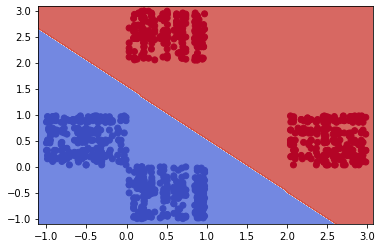

In [53]:
# create a mesh to plot 
h = 0.02
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm)

In [54]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(1,2)
#         self.linear2 = nn.Linear(8,16)
#         self.linear3 = nn.Linear(16,3)
    def forward(self,x):
        x = self.linear1(x)
#         x = F.relu(self.linear2(x))
#         x = self.linear3(x)
        return x

In [55]:
what =Whatnet().double()
#what(out_avg)

In [56]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [57]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    #inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    avg_inp,alphas = where(inputs)
    outputs = what(avg_inp)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 30000 train images: 0 %
total correct 0
total train set images 1000
focus_true_pred_true 0 =============> FTPT : 0 %
focus_false_pred_true 0 =============> FFPT : 0 %
focus_true_pred_false 485 =============> FTPF : 48 %
focus_false_pred_false 515 =============> FFPF : 51 %
argmax_more_than_half ==================>  1000
argmax_less_than_half ==================>  0
1000


In [58]:
def disp_plot(data,avg_data,i,true_label,pred_label,alpha,true_idx):
    plt.figure(figsize=(6,6))
    data = data.numpy()
    alpha = alpha.detach().numpy()
    avg_data = avg_data.detach().numpy()
    
    #print("data",data)
    #print("avg_data",avg_data)
    #print("alpha0",alpha[0])
    #print("alpha1",alpha[1])
    x = data[:,0] 
    y = data[:,1]
    
    
    #print(inputs[0])
    #print(x)
    #np.random.seed(1234)
    x1 = np.arange(0,10,1)#np.random.randint(low=0,high=10,size= x.size)
    #print("s",x)
    #print(avg_data[0])
    for i in range(0,10):
        plt.plot([x[i],y[i]],[x1[i],x1[i]],'ro-')
        plt.scatter(avg_data[i],x1[i],marker="X",linewidths=10)
        


In [60]:
criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 100

train_loss=[]

train_acc = [] 
ig = np.random.randint(0,250)
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0
  
    argmax_more_than_half = 0
    argmax_less_than_half =0
    running_loss = 0.0
    running_acc = 0
    cnt=0
    c = 0
    iteration = desired_num // batch
    
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        
        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        
        
        
        # display plots 
        #print(inputs[:10])
        
        # if(c==0):
        #     #p = inputs[:10].numpy()
        #     #print("kkldsksd",p)
        #     #print("ddasdas",p[:,0])
        #     disp_plot(inputs[:10,:],avg_inp[:10],1,labels[:10].numpy()
        #               ,predicted[:10].numpy(), alphas[:10,:], fore_idx[:10].numpy())
        #     c+=1
            
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        running_acc+=sum(predicted.cpu().numpy()== labels.cpu().numpy())
        
        if cnt % 4 == 3:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss/4 ))
            print('[%d,%5d] accuracy: %.3f' %(epoch + 1, cnt+1,running_acc/1000))
            
            train_loss.append(running_loss)
            train_acc.append(running_acc /1000)
            running_loss = 0.0
            running_acc = 0
#             torch.save(where.state_dict(),"weight_elemental/where_model_epoch"+str(epoch)+".pt")
#             torch.save(what.state_dict(),"weight_elemental/what_model_epoch"+str(epoch)+".pt")
        cnt=cnt+1
        if epoch % 5 == 0:
          for j in range (batch):
            focus = torch.argmax(alphas[j])
            if (alphas[j][focus] >= 0.5):
              argmax_more_than_half +=1
            else:
              argmax_less_than_half +=1
            if (focus == fore_idx[j] and predicted[j] == labels[j]):
              focus_true_pred_true += 1
            elif (focus != fore_idx[j] and predicted[j] == labels[j]):
              focus_false_pred_true +=1
            elif (focus == fore_idx[j] and predicted[j] != labels[j]):
              focus_true_pred_false +=1
            elif (focus != fore_idx[j] and predicted[j] != labels[j]):
              focus_false_pred_false +=1
    if epoch % 5 == 0:
      col1.append(epoch + 1 )
      col2.append(argmax_more_than_half)
      col3.append(argmax_less_than_half)
      col4.append(focus_true_pred_true)
      col5.append(focus_false_pred_true)
      col6.append(focus_true_pred_false)
      col7.append(focus_false_pred_false)
        
print('Finished Training')
# torch.save(where.state_dict(),"weight_elemental/where_model_epoch"+str(nos_epochs)+".pt")
# torch.save(what.state_dict(),"weight_elemental/what_model_epoch"+str(epoch)+".pt")       
        
        
        

[1,     4] loss: 0.866
[1,    4] accuracy: 0.000
[2,     4] loss: 0.791
[2,    4] accuracy: 0.267
[3,     4] loss: 0.702
[3,    4] accuracy: 0.485
[4,     4] loss: 0.631
[4,    4] accuracy: 0.485
[5,     4] loss: 0.580
[5,    4] accuracy: 0.485
[6,     4] loss: 0.537
[6,    4] accuracy: 0.487
[7,     4] loss: 0.497
[7,    4] accuracy: 0.576
[8,     4] loss: 0.459
[8,    4] accuracy: 0.677
[9,     4] loss: 0.423
[9,    4] accuracy: 0.753
[10,     4] loss: 0.389
[10,    4] accuracy: 0.826
[11,     4] loss: 0.360
[11,    4] accuracy: 0.853
[12,     4] loss: 0.334
[12,    4] accuracy: 0.949
[13,     4] loss: 0.312
[13,    4] accuracy: 1.000
[14,     4] loss: 0.292
[14,    4] accuracy: 1.000
[15,     4] loss: 0.275
[15,    4] accuracy: 1.000
[16,     4] loss: 0.259
[16,    4] accuracy: 1.000
[17,     4] loss: 0.246
[17,    4] accuracy: 1.000
[18,     4] loss: 0.233
[18,    4] accuracy: 1.000
[19,     4] loss: 0.222
[19,    4] accuracy: 1.000
[20,     4] loss: 0.212
[20,    4] accuracy: 1.00

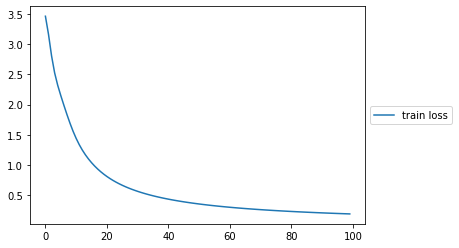

In [61]:
plt.plot(train_loss,label = "train loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

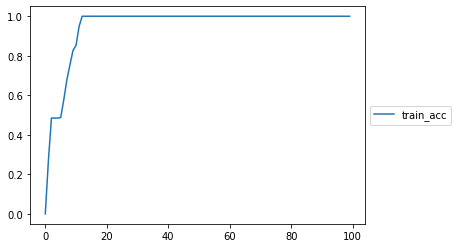

In [62]:
plt.plot(train_acc,label ="train_acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [65]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()


In [66]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7


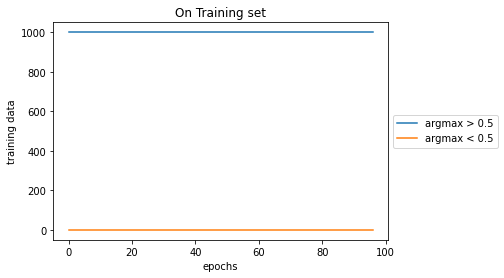

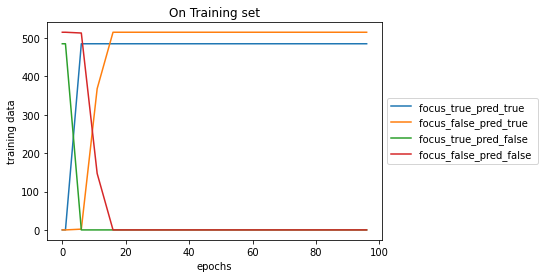

In [72]:
plt.figure(figsize=(6,4))
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()


plt.figure(figsize=(6,4))
plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()


In [68]:
for param in where.parameters():
  print(param)

Parameter containing:
tensor([[0.5036]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([-0.1424], dtype=torch.float64, requires_grad=True)


In [69]:
for param in what.parameters():
  print(param)

Parameter containing:
tensor([[-2.3773],
        [ 1.3718]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 2.3606, -1.3599], dtype=torch.float64, requires_grad=True)
